### 1. Importar les llibreries

In [854]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, roc_curve

****
### 2. Carregar el dataset

In [855]:
df = pd.read_csv('https://raw.githubusercontent.com/Nicolakorff/Projecte-Machine-Learning/refs/heads/main/datasets/bank_dataset_wins.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59.0,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1033,1,-1.0,0.0,unknown,yes
1,56.0,admin.,married,secondary,no,45,no,no,unknown,5,may,1033,1,-1.0,0.0,unknown,yes
2,41.0,technician,married,secondary,no,1270,yes,no,unknown,5,may,1033,1,-1.0,0.0,unknown,yes
3,55.0,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1.0,0.0,unknown,yes
4,54.0,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1.0,0.0,unknown,yes


In [856]:
# Columnes importants per al model: 'age', 'balance', 'loan', 'campaign', 'job', 'education', 'housing' i 'marital'.

df.drop("pdays", axis=1, inplace=True)
df.drop("default", axis=1, inplace=True)
df.drop("duration", axis=1, inplace=True)
df.drop("contact", axis=1, inplace=True)
df.drop("previous", axis=1, inplace=True)
df.drop("poutcome", axis=1, inplace=True)
df.drop("month", axis=1, inplace=True)
df.drop("day", axis=1, inplace=True)

df.to_csv('bank_dataset_cut.csv', index=False)

In [857]:
# transformar 'age' de float a integrer
df['age'] = df['age'].astype(int)

In [858]:
df.head()

,age,job,marital,education,balance,housing,loan,campaign,deposit
0,59,admin.,married,secondary,2343,yes,no,1,yes
1,56,admin.,married,secondary,45,no,no,1,yes
2,41,technician,married,secondary,1270,yes,no,1,yes
3,55,services,married,secondary,2476,yes,no,1,yes
4,54,admin.,married,tertiary,184,no,no,2,yes


In [859]:
# comprovar el balanç de classes de la variable de resultat
print(df['deposit'].value_counts(normalize=True) * 100)

deposit
no     52.616019
yes    47.383981
Name: proportion, dtype: float64


****
### 3. Divisió del dataset

In [860]:
# Després de comprovar el balanç de les classes es divideix el dataset en conjunts d'entrenament i prova en un 80/20.
# S'ha considerat el 80/20 el més adient per la quatitat de dades, el balaç de les classes i tipus diferent de dades.

# Definició de característicques (X) y variable de resultat (y).
X = df.drop(columns='deposit')  # Característiques
y = df['deposit']  # Variable de resultat

# Divisió en entrenamient (80%) y proba (20%) amb estratificació
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22, stratify=y)

# Verificar que la proporció de classes es mante en els dos conjunts
print("Grandària del conjunt d'entrenament (train):")
print(y_train.value_counts(normalize=True))
print("Grandària del conjunt de prova (test):")
print(y_test.value_counts(normalize=True))

Grandària del conjunt d'entrenament (train):
deposit
no     0.526151
yes    0.473849
Name: proportion, dtype: float64
Grandària del conjunt de prova (test):
deposit
no     0.526198
yes    0.473802
Name: proportion, dtype: float64


In [861]:
# Desar els conjunts en fitxers CSV
X_train.to_csv('bank_dataset_X_train.csv', index=False)
X_test.to_csv('bank_dataset_X_test.csv', index=False)
y_train.to_csv('bank_dataset_y_train.csv', index=False)
y_test.to_csv('bank_dataset_y_test.csv', index=False)

# Per facilitar el codi anomenem X_train = train ; X_test = test

train = X_train
test = X_test

# Comprovar les primeres files dels conjunts
train.head()

,age,job,marital,education,balance,housing,loan,campaign
4868,26,technician,single,secondary,181,no,no,2
486,26,services,single,secondary,-189,no,yes,2
2466,59,retired,divorced,tertiary,3444,no,no,1
5952,43,housemaid,married,primary,0,yes,no,3
1721,25,student,single,secondary,1608,no,no,2


In [862]:
test.head()

,age,job,marital,education,balance,housing,loan,campaign
8771,25,admin.,single,secondary,483,no,yes,1
2823,74,retired,married,secondary,4087,no,no,2
9911,28,services,married,secondary,4,yes,no,5
5111,27,admin.,married,secondary,1595,no,no,2
5682,36,management,single,tertiary,13,no,yes,1


- S' ajusta els conjunts train i test en transformació/codificació de variables.
- Inicialment s'aplica l'escalador unicament al conjunt de train i s´aplicar posteriorment sense ajustar al conjunt de test.

****
### 4. Transformar variables categóriques

In [863]:
train2 = train.copy()
test2 = test.copy()
# Veure els valors únics a la columna 'education'
unique_education_train = train2['education'].unique()
print(unique_education_train)

['secondary' 'tertiary' 'primary' 'unknown']


In [864]:
# Us del mappeig manual, per endreçar ordinalment escullint l'enumaració
# Especificar l'ordre amb el diccionari
education_map = {'secondary': 2, 'tertiary': 3, 'primary': 1, 'unknown': 0}

# Aplicar el mappeig a la columna
train2['education_encoded'] = train2['education'].map(education_map)
test2['education_encoded'] = test2['education'].map(education_map)

# Verificar les etiquetes amb els sus codis
print(train2[['education', 'education_encoded']].drop_duplicates())
print(test2[['education', 'education_encoded']].drop_duplicates())

      education  education_encoded
4868  secondary                  2
2466   tertiary                  3
5952    primary                  1
5250    unknown                  0
       education  education_encoded
8771   secondary                  2
5682    tertiary                  3
11097    primary                  1
3784     unknown                  0


In [865]:
# Eliminar columnes originals:
train2.drop("education", axis=1, inplace=True)
test2.drop("education", axis=1, inplace=True)

In [866]:
# Transformació de la variable 'job' fent una agrupació de les categories per reduir dimensionalitat
unique_job = train2['job'].unique()
print(unique_job)

['technician' 'services' 'retired' 'housemaid' 'student' 'management'
 'unemployed' 'admin.' 'self-employed' 'entrepreneur' 'blue-collar'
 'unknown']


In [867]:
# Agrupació de la variable 'job'
# Mappeig
job_groups = {
    'admin.': 'qualified',
    'blue-collar': 'qualified',
    'technician': 'qualified',
    'management': 'qualified',
    'services': 'semi-qualified',
    'entrepreneur': 'freelance',
    'self-employed': 'freelance',
    'student': 'no qualified',
    'retired': 'qualified',
    'unemployed': 'no qualified',
    'housemaid': 'semi-qualified',
    'unknown': 'other'
}

In [868]:
# Aplicar el mappeig per agrupar categories
train2['job_grouped'] = train2['job'].map(job_groups)
test2['job_grouped'] = test2['job'].map(job_groups)

# Verificar la nova columna
print(train2[['job', 'job_grouped']].drop_duplicates()) 
print(test2[['job', 'job_grouped']].drop_duplicates()) 

                job     job_grouped
4868     technician       qualified
486        services  semi-qualified
2466        retired       qualified
5952      housemaid  semi-qualified
1721        student    no qualified
8789     management       qualified
3819     unemployed    no qualified
7949         admin.       qualified
4962  self-employed       freelance
4870   entrepreneur       freelance
9634    blue-collar       qualified
3253        unknown           other
                job     job_grouped
8771         admin.       qualified
2823        retired       qualified
9911       services  semi-qualified
5682     management       qualified
7405  self-employed       freelance
3772     technician       qualified
2609     unemployed    no qualified
5243    blue-collar       qualified
3511        unknown           other
2069      housemaid  semi-qualified
3326        student    no qualified
9393   entrepreneur       freelance


In [869]:
# Convertir a valors numérics
job_group_mapping = {'semi-qualified': 3, 'qualified': 2, 'retired': 0, 'other': 5, 'no qualified': 4, 'freelance': 1}
train2['job_grouped_encoded'] = train2['job_grouped'].map(job_group_mapping)
test2['job_grouped_encoded'] = test2['job_grouped'].map(job_group_mapping)

# Verificar els valors codificats
print(train2[['job_grouped', 'job_grouped_encoded']].drop_duplicates())
print(test2[['job_grouped', 'job_grouped_encoded']].drop_duplicates())

         job_grouped  job_grouped_encoded
4868       qualified                    2
486   semi-qualified                    3
1721    no qualified                    4
4962       freelance                    1
3253           other                    5
         job_grouped  job_grouped_encoded
8771       qualified                    2
9911  semi-qualified                    3
7405       freelance                    1
2609    no qualified                    4
3511           other                    5


In [870]:
# Eliminar columnes originals:
train2.drop("job", axis=1, inplace=True)
test2.drop("job", axis=1, inplace=True)

# Verificació:
train2.head()

,age,marital,balance,housing,loan,campaign,education_encoded,job_grouped,job_grouped_encoded
4868,26,single,181,no,no,2,2,qualified,2
486,26,single,-189,no,yes,2,2,semi-qualified,3
2466,59,divorced,3444,no,no,1,3,qualified,2
5952,43,married,0,yes,no,3,1,semi-qualified,3
1721,25,single,1608,no,no,2,2,no qualified,4


In [871]:
test2.head()

,age,marital,balance,housing,loan,campaign,education_encoded,job_grouped,job_grouped_encoded
8771,25,single,483,no,yes,1,2,qualified,2
2823,74,married,4087,no,no,2,2,qualified,2
9911,28,married,4,yes,no,5,2,semi-qualified,3
5111,27,married,1595,no,no,2,2,qualified,2
5682,36,single,13,no,yes,1,3,qualified,2


In [872]:
# Eliminar columnes job_grouped:
train2.drop("job_grouped", axis=1, inplace=True)
test2.drop("job_grouped", axis=1, inplace=True)

In [873]:
# One-Hot Encoding per 'loan', 'housing', 'deafult', 'marital', 'contact', ja que no es poden ordenar de foma ordinal
train3 = train2
test3 = test2

In [874]:
# Utilitzar get_dummies per a 'loan', 'housing', 'deafult', al ser columnes amb valors binaris
train3 = pd.get_dummies(train3, columns=['loan'], prefix='loan')
train3 = pd.get_dummies(train3, columns=['housing'], prefix='housing')
test3 = pd.get_dummies(test3, columns=['loan'], prefix='loan')
test3 = pd.get_dummies(test3, columns=['housing'], prefix='housing')

In [875]:
# Verificar les etiquetes amb els sus codis
print(train3[['loan_yes', 'loan_no']].drop_duplicates())
print(test3[['loan_yes', 'loan_no']].drop_duplicates())
print(train3[['housing_yes', 'housing_no']].drop_duplicates())
print(test3[['housing_yes', 'housing_no']].drop_duplicates())

      loan_yes  loan_no
4868     False     True
486       True    False
      loan_yes  loan_no
8771      True    False
2823     False     True
      housing_yes  housing_no
4868        False        True
5952         True       False
      housing_yes  housing_no
8771        False        True
9911         True       False


In [876]:
train3['loan'] = train3['loan_yes'].astype(int)
train3.drop(['loan_yes', 'loan_no'], axis=1, inplace=True)
test3['loan'] = test3['loan_yes'].astype(int)
test3.drop(['loan_yes', 'loan_no'], axis=1, inplace=True)
train3['housing'] = train3['housing_yes'].astype(int)
train3.drop(['housing_yes', 'housing_no'], axis=1, inplace=True)
test3['housing'] = test3['housing_yes'].astype(int)
test3.drop(['housing_yes', 'housing_no'], axis=1, inplace=True)

In [877]:
# Verificació
train3.head()

,age,marital,balance,campaign,education_encoded,job_grouped_encoded,loan,housing
4868,26,single,181,2,2,2,0,0
486,26,single,-189,2,2,3,1,0
2466,59,divorced,3444,1,3,2,0,0
5952,43,married,0,3,1,3,0,1
1721,25,single,1608,2,2,4,0,0


In [878]:
test3.head()

,age,marital,balance,campaign,education_encoded,job_grouped_encoded,loan,housing
8771,25,single,483,1,2,2,1,0
2823,74,married,4087,2,2,2,0,0
9911,28,married,4,5,2,3,0,1
5111,27,married,1595,2,2,2,0,0
5682,36,single,13,1,3,2,1,0


In [879]:
# Utilitzar get_dummies per a la variable de resultat'deposit', també de valors binaris
y_train = pd.get_dummies(y_train, columns=['deposit'], prefix='deposit')
y_test = pd.get_dummies(y_test, columns=['deposit'], prefix='deposit')
# Verificar les etiquetes amb els sus codis
print(y_train[['deposit_yes', 'deposit_no']].drop_duplicates())
print(y_test[['deposit_yes', 'deposit_no']].drop_duplicates())

      deposit_yes  deposit_no
4868         True       False
5952        False        True
      deposit_yes  deposit_no
8771        False        True
2823         True       False


In [880]:
y_train['deposit'] = y_train['deposit_yes'].astype(int)
y_train.drop(['deposit_yes', 'deposit_no'], axis=1, inplace=True)
y_test['deposit'] = y_test['deposit_yes'].astype(int)
y_test.drop(['deposit_yes', 'deposit_no'], axis=1, inplace=True)

In [881]:
train4=train3
test4=test3

In [882]:
# Crear i ajustar el OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train4[['marital']])

# Codificar
marital_encoded_train = encoder.transform(train4[['marital']])
marital_encoded_test = encoder.transform(test4[['marital']])

# Crear un DataFrame per a la codificació de 'marital'
marital_encoded_train_df = pd.DataFrame(marital_encoded_train, columns=encoder.get_feature_names_out(['marital']))
marital_encoded_test_df = pd.DataFrame(marital_encoded_test, columns=encoder.get_feature_names_out(['marital']))

# Resetejar els índexs per assegurar alineació
train4 = train4.reset_index(drop=True)
marital_encoded_train_df = marital_encoded_train_df.reset_index(drop=True)
test4 = test4.reset_index(drop=True)
marital_encoded_test_df = marital_encoded_test_df.reset_index(drop=True)

# Concatenar els DataFrames amb l'eix correcte (axis=1) per afegir les columnes codificades
train4 = pd.concat([train4, marital_encoded_train_df], axis=1)
test4 = pd.concat([test4, marital_encoded_test_df], axis=1)

# Verificar les columnes generades
print("Noves columnes codificades:", encoder.get_feature_names_out(['marital']))
print("Dimensions despres de concatenar:")
print("train4:", train4.shape)
print("test4:", test4.shape)

Noves columnes codificades: ['marital_divorced' 'marital_married' 'marital_single' 'marital_unknown']
Dimensions despres de concatenar:
train4: (8929, 12)
test4: (2233, 12)


In [883]:
# Eliminar columnes originals:
train4.drop("marital", axis=1, inplace=True)
test4.drop("marital", axis=1, inplace=True)

In [884]:
# Verificar:
train4.head()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,26,181,2,2,2,0,0,0.0,0.0,1.0,0.0
1,26,-189,2,2,3,1,0,0.0,0.0,1.0,0.0
2,59,3444,1,3,2,0,0,1.0,0.0,0.0,0.0
3,43,0,3,1,3,0,1,0.0,1.0,0.0,0.0
4,25,1608,2,2,4,0,0,0.0,0.0,1.0,0.0


In [885]:
test4.head()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,25,483,1,2,2,1,0,0.0,0.0,1.0,0.0
1,74,4087,2,2,2,0,0,0.0,1.0,0.0,0.0
2,28,4,5,2,3,0,1,0.0,1.0,0.0,0.0
3,27,1595,2,2,2,0,0,0.0,1.0,0.0,0.0
4,36,13,1,3,2,1,0,0.0,0.0,1.0,0.0


In [886]:
# Desar el DataFrame estandarditzat en un fitxer CSV
train4.to_csv('bank_dataset_X_train_stand.csv', index=False)
test4.to_csv('bank_dataset_X_test_stand.csv', index=False)
y_train.to_csv('bank_dataset_y_train_stand.csv', index=False)
y_test.to_csv('bank_dataset_y_test_stand.csv', index=False)

****
### 5. Estandarització o Normalització de les dades

**5.1 Tractactament d'outliers al conjunt train**

In [887]:
train5 = pd.read_csv('bank_dataset_X_train_stand.csv')
test5 = pd.read_csv('bank_dataset_X_test_stand.csv')

In [888]:
train5.head()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,26,181,2,2,2,0,0,0.0,0.0,1.0,0.0
1,26,-189,2,2,3,1,0,0.0,0.0,1.0,0.0
2,59,3444,1,3,2,0,0,1.0,0.0,0.0,0.0
3,43,0,3,1,3,0,1,0.0,1.0,0.0,0.0
4,25,1608,2,2,4,0,0,0.0,0.0,1.0,0.0


In [889]:
## Detecció d'outliers
# Llistar columnes a detectar outliers
columns_to_check = ['age', 'balance', 'campaign',]

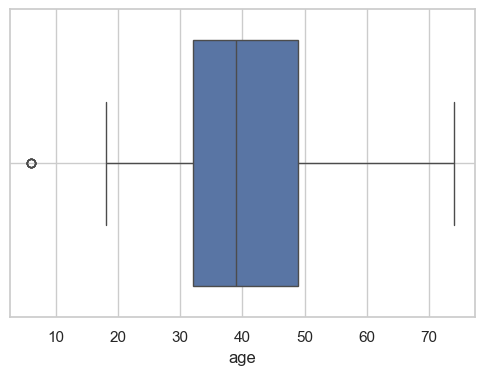

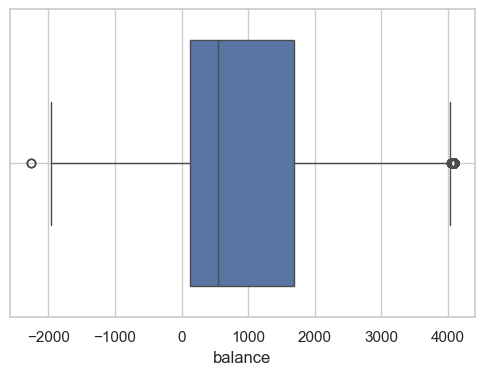

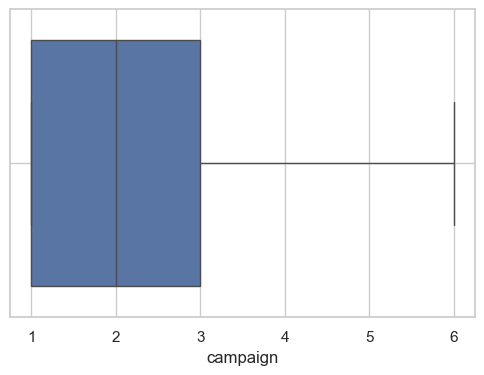

In [890]:
# Crear diagrames de caixa per visualitzar outliers a cada columna
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train4[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # S'han detectat outliers a 'age' i 'balance'.

In [891]:
# Tractar outliers aplicant la técnica de Winsorització per mantenir l'estructura del dataset
# Funció per calcular límits IQR
def calculate_iqr_limits(train5, columns):
    limits_dict = {}
    
    for column in columns:
        Q1 = train5[column].quantile(0.25)
        Q3 = train5[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        limits_dict[column] = (lower_bound, upper_bound)
        
    return limits_dict

In [892]:
# Funció per winsoritzar dades
def winsorize_data(train5, columns):
    limits_dict = calculate_iqr_limits(train5, columns)
    
    for column, (lower_bound, upper_bound) in limits_dict.items():
        # Winsoritzar: Reemplaçar valors menors al límit inferior i majores al límit superior
        train5[column] = np.clip(train5[column], lower_bound, upper_bound)
        
    return train5

In [893]:
# Definir les columnas a winsoritzar
columns_to_check = ['balance', 'age']

# Aplicar winsorització a les columnes especificades
train_winsorized = winsorize_data(train5, columns_to_check)
test_winsorized = winsorize_data(test5, columns_to_check)

# Guardar el DataFrame en un archiu CSV
train_winsorized.to_csv('bank_dataset_X_train_stand.csv', index=False)
test_winsorized.to_csv('bank_dataset_X_test_stand.csv', index=False)

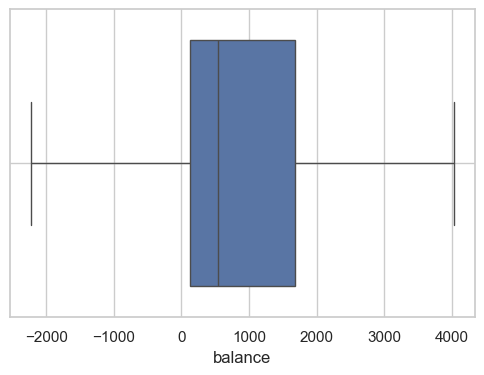

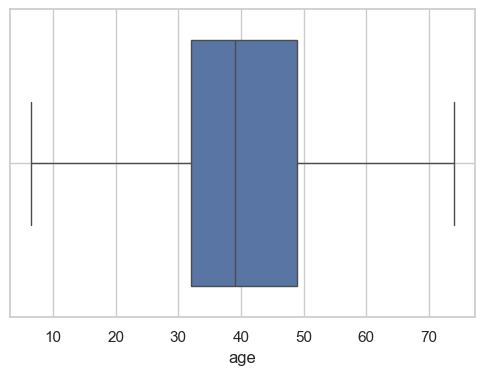

In [894]:
# Comprobar que no hi hagi outliers
for column in columns_to_check:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_winsorized[column])
    plt.xlabel(column)
    plt.grid(True)
    plt.show() # No es detecten outliers

In [896]:
train_winsorized.head()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,26.0,181,2,2,2,0,0,0.0,0.0,1.0,0.0
1,26.0,-189,2,2,3,1,0,0.0,0.0,1.0,0.0
2,59.0,3444,1,3,2,0,0,1.0,0.0,0.0,0.0
3,43.0,0,3,1,3,0,1,0.0,1.0,0.0,0.0
4,25.0,1608,2,2,4,0,0,0.0,0.0,1.0,0.0


In [897]:
# Obtenir una descripció estadística del DataFrame
train_winsorized.describe()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,41.159256,1102.708254,2.236085,2.106171,2.192631,0.130810,0.475193,0.114459,0.569493,0.315601,0.000448
std,11.680589,1334.265759,1.523646,0.797436,0.676397,0.337211,0.499412,0.318385,0.495175,0.464781,0.021162
min,6.500000,-2224.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,122.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,546.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,49.000000,1686.000000,3.000000,3.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,74.000000,4032.000000,6.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [898]:
# Mostrar les primeres 5 filas del DataFrame
test_winsorized.head()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
0,25.0,483,1,2,2,1,0,0.0,0.0,1.0,0.0
1,74.0,4087,2,2,2,0,0,0.0,1.0,0.0,0.0
2,28.0,4,5,2,3,0,1,0.0,1.0,0.0,0.0
3,27.0,1595,2,2,2,0,0,0.0,1.0,0.0,0.0
4,36.0,13,1,3,2,1,0,0.0,0.0,1.0,0.0


In [899]:
# Obtenir una descripció estadística del DataFrame
test_winsorized.describe()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,40.948052,1155.190327,2.248545,2.103448,2.173757,0.130766,0.464845,0.120466,0.566055,0.313032,0.000448
std,11.676742,1364.910971,1.511464,0.790599,0.650538,0.337220,0.498874,0.325578,0.495729,0.463831,0.021162
min,6.500000,-2257.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,126.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,560.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,49.000000,1794.000000,3.000000,3.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,74.000000,4087.000000,6.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


****
**5.3 Estandarització de variables numériques del conjunt train i test**

In [900]:
# Crear una copia para no afectar los datos originales
train6 = train_winsorized.copy()
test6 = test_winsorized.copy()

In [831]:
# Convé estandaritzar les variables numèriques que tenen una escala àmplia i que podrien afectar els models
# Especificar les columnes numèriques a estandarditzar
columns_to_standardize = ['age', 'balance', 'campaign']

In [901]:
print("Valores mínimos antes de transformación:")
print("balance:", train6['balance'].min())
print("campaign:", train6['campaign'].min())
print("age:", train6['age'].min())

Valores mínimos antes de transformación:
balance: -2224
campaign: 1
age: 6.5


In [902]:
print(train6[columns_to_standardize].mean())

age           41.159256
balance     1102.708254
campaign       2.236085
dtype: float64


In [903]:
# Instanciar el escalador
scaler = RobustScaler()
# Aplicar RobustScaler a múltiples columnas
train6[columns_to_standardize] = scaler.fit_transform(train6[columns_to_standardize])
test6[columns_to_standardize] = scaler.transform(test6[columns_to_standardize])

In [904]:
# Guardar el DataFrame estandaritzat en el mateix arxiu CSV
train6.to_csv('bank_dataset_X_train_stand.csv', index=False)
test6.to_csv('bank_dataset_X_test_stand.csv', index=False)

In [905]:
# Comprovar la mitja de les columnes estandaritzades en train5
print("Mitja de cada columna en train6 despres d'estandaritzar:")
print(train6[columns_to_standardize].mean())
print("Mitja de cada columna en test6 despres d'estandaritzar:")
print(test6[columns_to_standardize].mean())

# Comprovar la desviació estándart de les columnes estandaritzades en train5
print("\nDesviació estándart de cada columna en train6 despres d'estandaritzar:")
print(train6[columns_to_standardize].std())
print("\nDesviació estándart de cada columna en test6 despres d'estandaritzar:")
print(test6[columns_to_standardize].std())

Mitja de cada columna en train6 despres d'estandaritzar:
age         0.127015
balance     0.355952
campaign    0.118042
dtype: float64
Mitja de cada columna en test6 despres d'estandaritzar:
age         0.114591
balance     0.389508
campaign    0.124272
dtype: float64

Desviació estándart de cada columna en train6 despres d'estandaritzar:
age         0.687093
balance     0.853111
campaign    0.761823
dtype: float64

Desviació estándart de cada columna en test6 despres d'estandaritzar:
age         0.686867
balance     0.872705
campaign    0.755732
dtype: float64


In [906]:
# Verificar estandarització.
train6.describe()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,0.127015,0.355952,0.118042,2.106171,2.192631,0.130810,0.475193,0.114459,0.569493,0.315601,0.000448
std,0.687093,0.853111,0.761823,0.797436,0.676397,0.337211,0.499412,0.318385,0.495175,0.464781,0.021162
min,-1.911765,-1.771100,-0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.411765,-0.271100,-0.500000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.588235,0.728900,0.500000,3.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,2.058824,2.228900,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


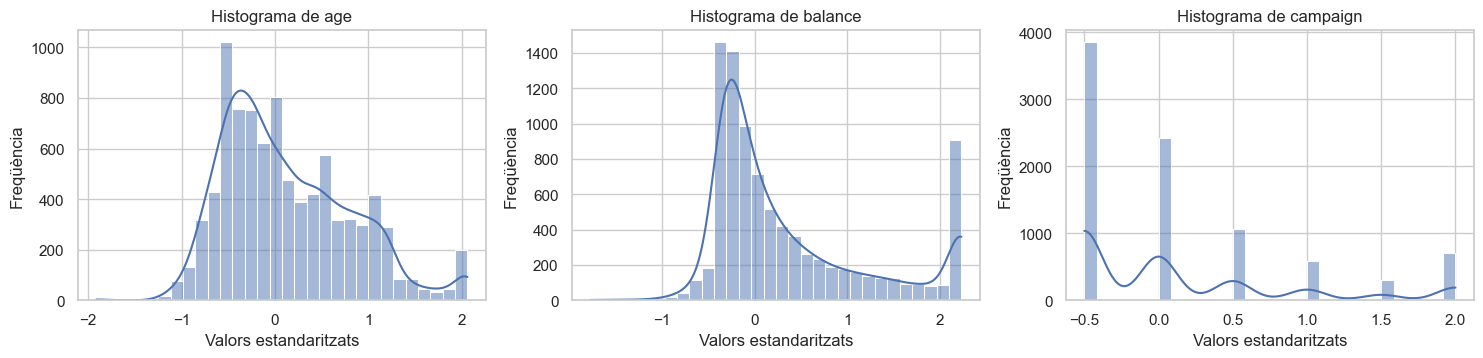

In [907]:
# Selecciona les variables estandaritzades en train5
variables_estandarizadas = train6[['age', 'balance', 'campaign']]

# Configurar la mida i estil
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Crear histogrames per a cada variable
for i, column in enumerate(variables_estandarizadas.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(variables_estandarizadas[column], bins=30, kde=True)
    plt.title(f'Histograma de {column}')
    plt.xlabel('Valors estandaritzats')
    plt.ylabel('Freqüència')

plt.tight_layout()
plt.show()

In [908]:
# Verificar estandarització.
test6.describe()

,age,balance,campaign,education_encoded,job_grouped_encoded,loan,housing,marital_divorced,marital_married,marital_single,marital_unknown
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,0.114591,0.389508,0.124272,2.103448,2.173757,0.130766,0.464845,0.120466,0.566055,0.313032,0.000448
std,0.686867,0.872705,0.755732,0.790599,0.650538,0.337220,0.498874,0.325578,0.495729,0.463831,0.021162
min,-1.911765,-1.792199,-0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.411765,-0.268542,-0.500000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.058824,0.008951,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.588235,0.797954,0.500000,3.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,2.058824,2.264066,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


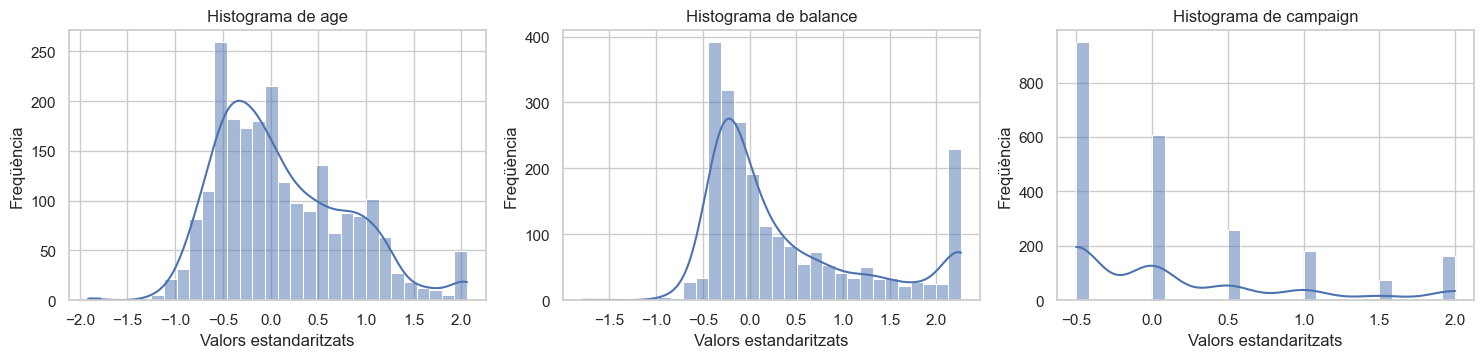

In [909]:
# Selecciona les variables estandaritzadas en test5
variables_estandarizadas = test6[['age', 'balance', 'campaign']]

# Configurar la mida i estil
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

# Crear histogrames per a cada variable
for i, column in enumerate(variables_estandarizadas.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(variables_estandarizadas[column], bins=30, kde=True)
    plt.title(f'Histograma de {column}')
    plt.xlabel('Valors estandaritzats')
    plt.ylabel('Freqüència')

plt.tight_layout()
plt.show()

****

### 6. Entrenar els models

In [910]:
train7 = train6
test7 = test6

****
### 6.1. Entrenament i Avaluació del Model K-means

- Seleccionar el nombre optim de Clusters 𝑘 per K-means.

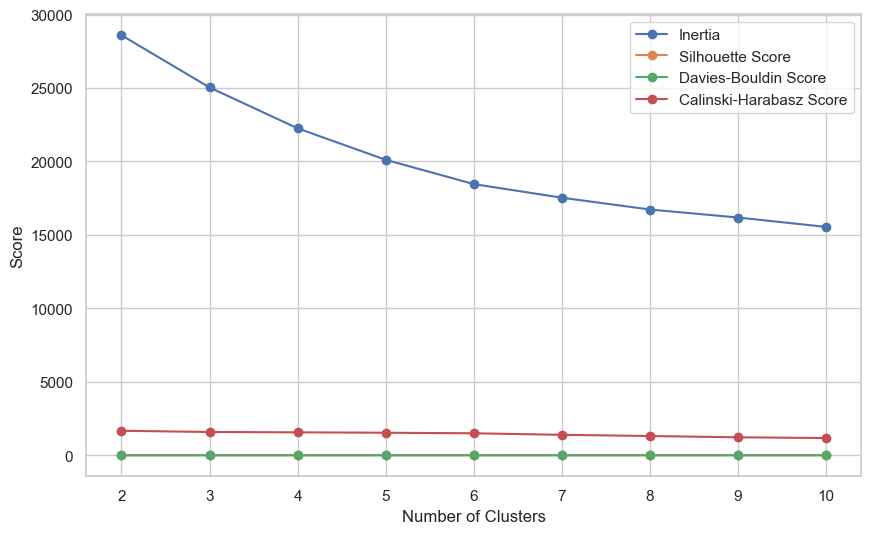

In [911]:
inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(train7)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(train7, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(train7, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(train7, cluster_labels))

# Plot results to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', label='Inertia')
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.plot(cluster_range, davies_bouldin_scores, marker='o', label='Davies-Bouldin Score')
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

In [912]:
## Fem una comprovació per veure quin seria el numero de clusters més adient:
results = []
for k in range(2, 10):  # Comprovació amb valors de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    clusters = kmeans.fit_predict(train7.drop(columns='cluster', errors='ignore'))
    
    inercia = kmeans.inertia_
    silhouette = silhouette_score(train7.drop(columns='cluster', errors='ignore'), clusters)
    davies_bouldin = davies_bouldin_score(train7.drop(columns='cluster', errors='ignore'), clusters)
    calinski_harabasz = calinski_harabasz_score(train7.drop(columns='cluster', errors='ignore'), clusters)
    
    results.append((k, inercia, silhouette, davies_bouldin, calinski_harabasz))

# Mostrar els resultats
for k, inercia, silhouette, davies_bouldin, calinski_harabasz in results:
    print(f"k={k}: Inercia={inercia:.2f}, Silueta={silhouette:.3f}, Davies-Bouldin={davies_bouldin:.3f}, Calinski-Harabasz={calinski_harabasz:.2f}")

k=2: Inercia=30006.38, Silueta=0.179, Davies-Bouldin=2.028, Calinski-Harabasz=1165.82
k=3: Inercia=25291.94, Silueta=0.193, Davies-Bouldin=1.802, Calinski-Harabasz=1523.39
k=4: Inercia=22254.80, Silueta=0.182, Davies-Bouldin=1.755, Calinski-Harabasz=1560.07
k=5: Inercia=21105.14, Silueta=0.188, Davies-Bouldin=1.753, Calinski-Harabasz=1355.18
k=6: Inercia=19265.71, Silueta=0.195, Davies-Bouldin=1.620, Calinski-Harabasz=1357.91
k=7: Inercia=17554.69, Silueta=0.200, Davies-Bouldin=1.498, Calinski-Harabasz=1386.68
k=8: Inercia=17220.08, Silueta=0.170, Davies-Bouldin=1.716, Calinski-Harabasz=1236.31
k=9: Inercia=16457.14, Silueta=0.167, Davies-Bouldin=1.793, Calinski-Harabasz=1183.48


In [913]:
# Entrenar el model K-means:
k = 3  # Es decideix que el més adient es aquest

# Crear y ajustar el modelo K-means
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(train7) 
clusters = kmeans.predict(train7)
kmeans.fit(test7) 
clusters_test = kmeans.predict(test7)

# Asignar els clusters al DataFrame
train8 = train7.copy()  # Crear una copia per evitar errors de referencia
train8['cluster'] = clusters
test8 = test7.copy()  # Crear una copia per evitar errors de referencia
test8['cluster'] = clusters_test

- Escollim el numero de clusters que tingui el nivell més baix de l'índex de Davies-Bouldini, el més alt de Calinski_Harbasz i el més estable possible en baixada d'inercia.

In [914]:
# Calcular mètriques per a K-means
# Inèrcia (Suma de Quadrats de Distàncies Internes)
inercia = kmeans.inertia_
print("Inèrcia:", inercia)

# Coeficient de Silueta
silhouette = silhouette_score(train8.drop(columns='cluster'), clusters)
print("Índex de Silueta:", silhouette)

# Índex de Davies-Bouldin
davies_bouldin = davies_bouldin_score(train8.drop(columns='cluster'), clusters)
print("Índex de Davies-Bouldin:", davies_bouldin)

# Índex de Calinski-Harabasz
calinski_harabasz = calinski_harabasz_score(train8.drop(columns='cluster'), clusters)
print("Índex de Calinski-Harabasz:", calinski_harabasz)

Inèrcia: 6259.834645649804
Índex de Silueta: 0.1928505904091445
Índex de Davies-Bouldin: 1.801613299216614
Índex de Calinski-Harabasz: 1523.391824583709


In [915]:
# Redimensionar para mejorar el índice de silueta
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(train8)

kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X_pca)

silhouette_avg = silhouette_score(X_pca, labels)
print("Índice de Silueta después de PCA:", silhouette_avg)

Índice de Silueta después de PCA: 0.4080295817574929


In [916]:
print("Columnes de train8:", train8.columns)
print("Columnes de test8:", test8.columns)

Columnes de train8: Index(['age', 'balance', 'campaign', 'education_encoded',
       'job_grouped_encoded', 'loan', 'housing', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'cluster'],
      dtype='object')
Columnes de test8: Index(['age', 'balance', 'campaign', 'education_encoded',
       'job_grouped_encoded', 'loan', 'housing', 'marital_divorced',
       'marital_married', 'marital_single', 'marital_unknown', 'cluster'],
      dtype='object')


****
### 6.2. Entrenament i Avaluació del Model de Regressió Logística

In [917]:
# variable objectiu
y = y_train['deposit']
yy = y_test['deposit']
print(y.shape)
print(yy.shape)

(8929,)
(2233,)


In [918]:
# Entrenar el model de Regressió Logística
# Crear i ajustar el model
model = LogisticRegression(random_state=0)
model.fit(train8, y)

# Predecir en el conjunto de prueba
y_pred = model.predict(test8)
y_proba = model.predict_proba(test8)[:, 1]  # Probabilidades para calcular ROC y Log-Loss

In [919]:
# Calcular les mètriques per a la Regressió Logística
# Curva ROC y AUC
auc = roc_auc_score(yy, y_proba)
print("AUC:", auc)

fpr, tpr, _ = roc_curve(yy, y_proba)

# Exactitud (Accuracy)
accuracy = accuracy_score(yy, y_pred)
print("Exactitud (Accuracy):", accuracy)

# Precisió (Precision)
precision = precision_score(yy, y_pred)
print("Precisión (Precision):", precision)

# Recall (Sensibilidad)
recall = recall_score(yy, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(yy, y_pred)
print("F1 Score:", f1)

# Matriu de Confusió
confusion = confusion_matrix(yy, y_pred)
print("Matriz de Confusión:\n", confusion)

# Log-Loss
logloss = log_loss(yy, y_proba)
print("Log-Loss:", logloss)

AUC: 0.6831412138519085
Exactitud (Accuracy): 0.6484549932825795
Precisión (Precision): 0.6369107321965898
Recall: 0.6001890359168242
F1 Score: 0.6180048661800487
Matriz de Confusión:
 [[813 362]
 [423 635]]
Log-Loss: 0.6426251429175813


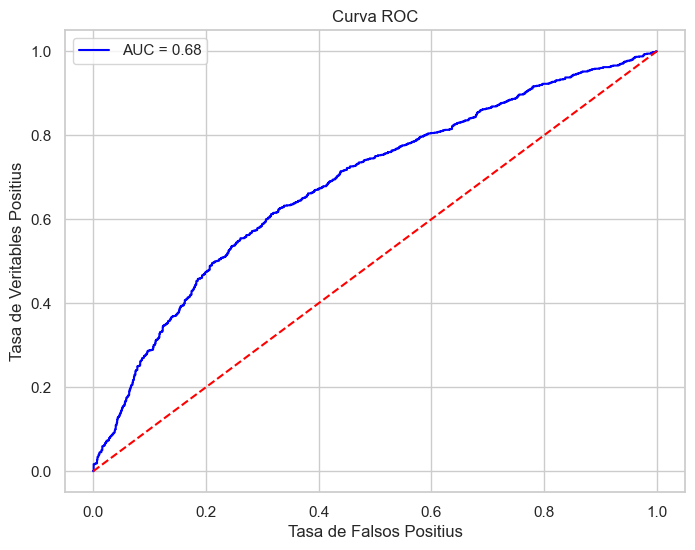

In [920]:
# Visualització
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Tasa de Falsos Positius')
plt.ylabel('Tasa de Veritables Positius')
plt.title('Curva ROC')
plt.legend()
plt.show()

****
### 7. Guardar el model i l'escalador

In [921]:
# Guardar els models
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('kmeans_model.pkl', 'rb') as f:
    kmeans = pickle.load(f)

with open('logistic_model.pkl', 'rb') as f:
    model = pickle.load(f)

****
### 8. Resultats dels models

**Resultats del K-means (Clustering)**

- La inèrcia amb un valor de 6259.83 mesura la suma de les distàncies dels punts al seu centreide a cada clúster, com més a prop millor l'agrupació.
- El coeficient de Silueta amb valor 0.40 després de la transformació extra amb PCA indica que els clústers estan moderadament ben definits, hi podria haver una mica de solapació.
- L'índex de Davies-Bouldin amb un valor de 1.80 mesura la capacitat de separació dels clústers, valors baixos indiquen una millor separació entre clústers. El valor és acceptable, però relativament alt, cosa que reforça la idea que els clústers podrien estar solapant-se i no ser tan diferents entre si.
- L'índex de Calinski-Harabasz amb un valor de 1523.39 avalua la separació i la compactació dels clusters. Un valor més alt indica millors clústers. Tot i que aquest valor sembla raonable, combinat amb l'índex de silueta, suggereix que els clústers podrien no ser gaire robustos.

**Resultats del Model de Regressió Logística**

- La mètrica AUC (Àrea Sota la Corba ROC) amb un valor de 0.68 és indicador que el model té una capacitat raonable per distingir entre els clients que probablement compraran un dipòsit i els que no ho faran. Un valor proper a 1 suggereix un model molt precís, mentre que un valor proper a 0.5 indicaria que el model és semblant a una elecció aleatòria. Atès que el valor és raonable, la regressió logística és efectiva per predir la probabilitat de compra als segments.
- La mètrica d'Exactitud (Accuracy) amb un valor de 0.65 indica amb una exactitud de 65% que el model és mitjanament bo per predir correctament si un client comprarà o no un dipòsit, però té marge de millora.
- Precisió (Precision) amb un valor de 0.64 dóna una precisió de 64%, cosa que significa que de totes les prediccions de clients que el model va fer com a compradors de dipòsits, el 64% realment ho seran. Un valor alt és favorable perquè indica que el model no està fent falses compres positives, cosa que és favorable per a una bona predicció.
- Recall (Sensibilitat) amb un valor de 0.60 indica que el model captura un 60% de tots els clients que realment comprarien un dipòsit. Un valor relativament alt és positiu, però un baix recall podria significar que alguns clients potencials estan sent passats per alt. El valor obtingut com a la resta de mètriques és moderada.
- F1-Score amb valor 0.62 és una mètrica de balanç entre precisió i recall. Un F1-score de 0.62 suggereix que el model està equilibrat en termes de precisió i recall, la qual cosa és generalment desitjable quan es tenen totes dues mètriques a considerar.
- La Matriu de Confusió mostra un resultat de [[813 362][423 635]] el que es tradueix en 813 clients correctament classificats com a no compradors, 635 clients correctament classificats com a compradors, 423 clients falsament classificats com a compradors (falsos positius) i 362 clients falsament classificats com a no compradors (falsos negatius). Els falsos negatius són especialment importants aquí, ja que són clients que en realitat comprarien un dipòsit, però que el model no els identifica. Això podria implicar que hi ha clients potencials que es podrien estar guanyant si es prenen mesures de millora de vendes.
- Finalment la mètrica Log-Loss amb un valor de 0.64. Com més baix millor, ja que indica que el model té menys incertesa en les seves prediccions. Amb 0.64, el model sembla raonablement fiable en les seves estimacions de probabilitat, però encara hi ha marge per millorar.

****
### 9. Conclusions finals

**Segmentació de Clients:**
- Els resultats del K-means suggereixen que els clústers no estan perfectament definits, cosa que podria indicar que els segments de clients encara poden estar solapant-se o que hi ha més complexitat en les dades que K-means no ha capturat bé. Tot i això, la segmentació encara és útil per identificar patrons i segmentar grups per personalitzar les estratègies de màrqueting.

**Regressió Logística:**
- El model de regressió logística té un rendiment just, amb una AUC de 0,68 i una precisió de 64%. Això indica que el model pot predir qui és més probable que compri un dipòsit, però no gaire precis. Tot i això, és important tenir en compte que el recall és 0.60, la qual cosa suggereix que hi ha un 40% de possibles clients potencials que el model no està identificant. Això podria significar que alguns clients amb alta probabilitat de compra no estan sent aconseguits.

**Estratègia de Màrqueting:**
- Segments de clients amb alta probabilitat de conversió han de ser el focus de les campanyes, especialment aquells amb una alta probabilitat predita de comprar un dipòsit (segons la regressió logística) com són els clústers 1 i 3.
- Clúster 1: Clients de mitjana edat (35-50 anys), amb balanços alts, interessats en productes financers complexos.
- Clúster 3: Clients joves (25-35 anys) que recentment van interactuar amb el banc amb trucades llargues o altres víes de comunicació.
- Clients amb alta probabilitat de compra (prediccions positives) però falsos negatius han de ser abordats amb campanyes de màrqueting més agressives o diferents estratègies de targeting.
- Es recomanen campanyes enfocades amb promocions i esforços de vendes als segments amb més probabilitat, com els clústers 1 i 3.
- Optimització del canal de contacte maximitzant l'ús de canals preferits pels segments més propensos com utilitzar el contacte telefònic al clúster 1.
- I personalitzar productes personalitzats dissenyant dipòsits que siguin més atractius per als segments amb menys propensió, com ara joves amb balanços baixos.

****